In [70]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import random
from collections import namedtuple
import matplotlib.pyplot as plt

In [71]:
class DQN(nn.Module):
    def __init__(self, input_size, output_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [72]:
Experience = namedtuple('Experience', ['state', 'action', 'next_state', 'reward', 'done', 'truncated'])

In [73]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0

    def push(self, experience):
        if len(self.buffer) < self.capacity:
            self.buffer.append(experience)
        else:
            self.buffer[self.position] = experience
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

In [74]:
class DQNAgent:
    def __init__(self, state_size, action_size, gamma=0.99, epsilon_start=1.0, epsilon_end=0.01, epsilon_decay=0.995):
        self.device = "mps"
        self.q_network = DQN(state_size, action_size).to(self.device)
        self.target_network = DQN(state_size, action_size).to(self.device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        self.target_network.eval()

        self.optimizer = optim.Adam(self.q_network.parameters(), lr=1e-3)
        self.loss_fn = nn.MSELoss()

        self.gamma = gamma
        self.epsilon = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay

    def select_action(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, 1)
        else:
            with torch.no_grad():
                state = torch.tensor(state, dtype=torch.float32).to(self.device)
                q_values = self.q_network(state)
                return torch.argmax(q_values).item()

    def update_model(self, experiences, batch_size):
        batch = Experience(*zip(*experiences))
        state_batch = torch.tensor(batch.state, dtype=torch.float32).to(self.device)
        action_batch = torch.tensor(batch.action).unsqueeze(1).to(self.device)
        next_state_batch = torch.tensor(batch.next_state, dtype=torch.float32).to(self.device)
        reward_batch = torch.tensor(batch.reward, dtype=torch.float32).to(self.device)
        done_batch = torch.tensor(batch.done, dtype=torch.float32).to(self.device)

        current_q_values = self.q_network(state_batch).gather(1, action_batch)
        next_q_values = self.target_network(next_state_batch).max(1)[0].detach()

        target_q_values = reward_batch + (1 - done_batch) * self.gamma * next_q_values

        loss = self.loss_fn(current_q_values, target_q_values.unsqueeze(1))

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_epsilon(self):
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_end)

In [83]:
def train_dqn(env_name='CartPole-v1', num_episodes=500, batch_size=64, buffer_capacity=10000):
    env = gym.make(env_name)
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n

    agent = DQNAgent(state_size, action_size)

    replay_buffer = ReplayBuffer(buffer_capacity)

    rewards, moving_avg_rewards = [], []
    moving_avg_window = 20

    for episode in range(num_episodes):
        state = env.reset()
        total_reward = 0
        done, truncated = False, False

        while not done and not truncated:
            if len(state) == 2: state = state[0]
            action = agent.select_action(state)
            next_state, reward, done, truncated, _ = env.step(action)
            total_reward += reward

            experience = Experience(state, action, next_state, reward, done, truncated)
            replay_buffer.push(experience)

            state = next_state

            if len(replay_buffer.buffer) > batch_size:
                batch = replay_buffer.sample(batch_size)
                agent.update_model(batch, batch_size)

        agent.update_epsilon()

        if episode % 10 == 0:
            agent.target_network.load_state_dict(agent.q_network.state_dict())

        print(f"Episode: {episode + 1}, Total Reward: {total_reward}")

        # REWARDS
        rewards.append(total_reward)
        if len(rewards) >= moving_avg_window:
            avg_rewards = np.mean(rewards[-moving_avg_window:])
            moving_avg_rewards.append(avg_rewards)
        
    plt.plot(range(len(moving_avg_rewards)), moving_avg_rewards)
    plt.xlabel('Episode')
    plt.ylabel(f'Moving Average Reward (last {moving_avg_window} episodes)')
    plt.title('Moving Average Reward Over Episodes')
    plt.show()

    env.close()



Episode: 1, Total Reward: 14.0
Episode: 2, Total Reward: 18.0
Episode: 3, Total Reward: 12.0
Episode: 4, Total Reward: 13.0
Episode: 5, Total Reward: 18.0
Episode: 6, Total Reward: 35.0
Episode: 7, Total Reward: 29.0
Episode: 8, Total Reward: 21.0
Episode: 9, Total Reward: 16.0
Episode: 10, Total Reward: 18.0
Episode: 11, Total Reward: 22.0
Episode: 12, Total Reward: 28.0
Episode: 13, Total Reward: 12.0
Episode: 14, Total Reward: 13.0
Episode: 15, Total Reward: 12.0
Episode: 16, Total Reward: 24.0
Episode: 17, Total Reward: 15.0
Episode: 18, Total Reward: 42.0
Episode: 19, Total Reward: 15.0
Episode: 20, Total Reward: 16.0
Episode: 21, Total Reward: 24.0
Episode: 22, Total Reward: 26.0
Episode: 23, Total Reward: 19.0
Episode: 24, Total Reward: 24.0
Episode: 25, Total Reward: 15.0
Episode: 26, Total Reward: 12.0
Episode: 27, Total Reward: 12.0
Episode: 28, Total Reward: 19.0
Episode: 29, Total Reward: 10.0
Episode: 30, Total Reward: 24.0
Episode: 31, Total Reward: 19.0
Episode: 32, Tota

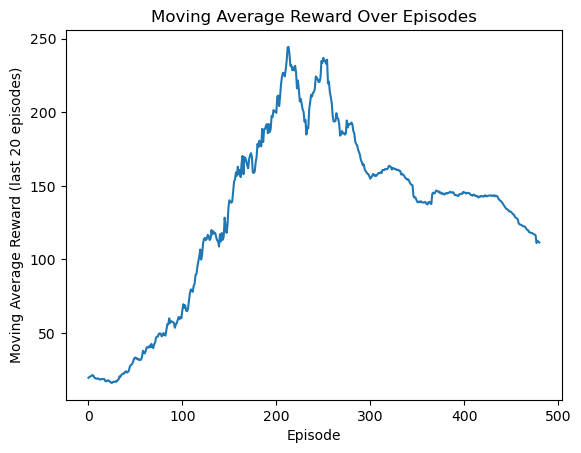

In [84]:
train_dqn()